In [1]:
"""Lean Project Valuation Model - a three-stage cashflow model.

This simulates a payoff process with pivot/exercise decisions as well as
fixed development and operations costs.

Typical usage example:

  payoff = PayoffProcess(...)
  c1, c2 = CashflowProcess(...), CashflowProcess(...)
  project_value = LeanProjectValuation(payoff, c1, c2).npv()

"""

import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from itertools import zip_longest
from scipy.stats.distributions import lognorm, rv_frozen
from pathlib import Path

from typing import Dict, Tuple, Sequence


In [2]:
# Helper Functions
def d2sl(d):
    """Convert dictionary to a sorted list"""
    return [v for k, v in sorted(d.items())]

def pv_annuity(payment, r, t):
    """Present value of annuity, continuously compounded"""
    return payment * (1-np.exp(-r*t))/(np.exp(r)-1)


In [3]:
# Simulation Parameters
N = 25        # no simulations
T = 3         # simulation periods
STEP = 20     # timesteps per period
DRIFT = 0.02  # cashflow drift rate
VOL = 1.0     # cashflow volatility
START = 3.0   # initial cashflow rate c0

# Plotting constants
TIME_ARRAY = np.linspace(0, T, STEP*T+1)
FIGSIZE = (6,4)


In [4]:
class CashflowProcess:
    """Cashflow Process - Geometric Brownian Motion (with optional drift)"""

    def __init__(self, mu: float = 0.0, sigma: float = 1.0, intercept: float = 3.0):
        """Initializes the cashflow processes based on drift and volatility parameters
        """
        self.mu = mu
        self.sigma = sigma
        self.intercept = intercept

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) -> np.ndarray:
        """Simulates n cashflow processes
        """
        # verify input
        assert t.ndim == 1, "One dimensional time vector required"
        assert t.size > 0, "At least one time point is required"
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), "Increasing time vector required"
        
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)

        # run simulation
        sim = (self.intercept-1) + np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T
        return sim

    def distribution(self, t: float) -> rv_frozen:
        """Return the distribution of the process
        """
        mu_t = (self.mu - self.sigma**2 / 2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)


class PayoffProcess(CashflowProcess):
    """Payoff Process - cashflow process with pivot shocks"""

    def __init__(self, mu: float = 0.0, sigma: float = 1.0, intercept: float = 3.0, threshold_array: np.array = None):
        """Initializes the payoff processes with drift and volatility
        """
        super().__init__(mu, sigma, intercept)
        self.thresholds = threshold_array
        self.pivot_shocks = []

    def _generate_pivot_shocks(self, stage_values: np.ndarray, threshold: Tuple, rnd: np.random.RandomState) -> np.ndarray:
        """Generates an array of shocks for a pivot stage given a threshold
        """
        cols = stage_values.shape[0]
        shocks = np.zeros(cols)

        if len(threshold) == 2:
                draws = rnd.uniform(0, 2, size=cols)
                mask = np.ma.masked_outside(stage_values, threshold[0], threshold[1])
                diff_mask = (mask * draws) - stage_values
                shocks = diff_mask.filled(0.0)
        
        self.pivot_shocks.append(shocks)
        return shocks


    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) -> np.ndarray:
        """Simulates n payoff processes by simulating cashflows between decision points
        and adding 1-period-forward pivot shocks when thresholds conditions are met
        """
        # iterate over thresholds, first element is for T=1
        threshold_arr = [(i+1,thr) for i, thr in enumerate(self.thresholds + [()])]

        # simulate a wiener process over the entire time array
        sim = super().simulate(t, n, rnd)

        # apply any same-stage pivot shocks, queue up future shocks
        pivot_shocks = np.zeros(n)
        for i, threshold in threshold_arr:
            # store the simulation index and values at the given period
            idx = np.where(t == i)[0][0]
            vals = sim[idx,:]
            
            # propagate any stored shocks
            remaining_rows = sim[idx:].shape[0]
            forward_shocks = np.tile(pivot_shocks, (remaining_rows,1))
            sim[idx:] += forward_shocks

            # store forward shocks for next stage
            pivot_shocks = self._generate_pivot_shocks(vals, threshold, rnd)
        
        return sim


class CostProcess(CashflowProcess):
    """Cost Process - constant cost process"""

    def __init__(self, intercept: float = 1.0):
        """Initializes constant cost processes as cashflows without drift or volatility
        """
        super().__init__(0, 0, intercept)


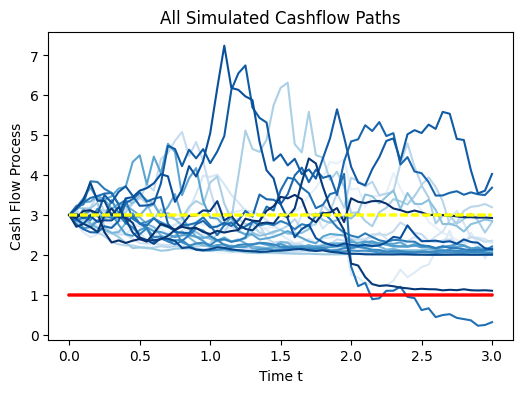

Payoff Process - trials: 25, drift: 0.02, vol: 1.0


In [11]:
# Cashflow Processes
po = PayoffProcess(mu=DRIFT, sigma=VOL, intercept=3.0, threshold_array=[(2.5,3.5)])
cd = CostProcess(1.0)  # development 
co = CostProcess(3.0)  # operations

# Simulate
rnd = RandomState(seed=1230)
payoff = po.simulate(TIME_ARRAY, N, rnd)
cost_dev = cd.simulate(TIME_ARRAY, N, rnd)
cost_ops = co.simulate(TIME_ARRAY, N, rnd)

assert payoff.shape == cost_dev.shape == cost_ops.shape, "All simulated cashflows must have the same shape"
assert payoff.all() > 0 and cost_dev.all() > 0 and cost_ops.all() >= 0, "All simulate cashflows must be non-negative"

# plot all cashflow and cost processes
plt.figure(figsize=FIGSIZE)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))

plt.plot(TIME_ARRAY, payoff)
plt.plot(TIME_ARRAY, cost_dev, color='red')
plt.plot(TIME_ARRAY, cost_ops, color='yellow', linestyle='dashed')

plt.title("All Simulated Cashflow Paths")
plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
plt.show()

txt = f"""Payoff Process - trials: {N}, drift: {DRIFT}, vol: {VOL}"""
print(txt)

In [14]:
po.pivot_shocks

[array([ 0.        ,  0.        ,  0.        , -1.06413597,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.02030779,  0.        ,
         0.        ,  0.        ,  0.        , -2.04097669,  1.06796869,
         0.        ,  0.        ,  0.        , -0.93477343,  0.88626295]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])]

In [7]:
class LeanProjectValuation:
    """Lean project valuation"""

    def __init__(self, cf_payoff: np.ndarray, cf_dev: np.ndarray, cf_ops: np.ndarray):
        """Initializes the project with a set of simulated cost and cashflows"""
        # store cashflows, decision array, and decision history
        self.cashflow = cf_payoff
        self.cost_dev = cf_dev
        self.cost_ops = cf_ops
        self.decisions = self._decision_fn()
        self.history = np.cumsum(self.decisions, axis=0)
        # exercise time and value series
        self.completion_times, self.completion_vals = {}, {}
        self.abandon_times, self.abandon_vals = {}, {}
        self.success_times, self.success_vals = {}, {}
        self.failure_times, self.failure_vals = {}, {}
        self.continue_times, self.continue_vals = {}, {}
        # exercise results
        self.paths = {}

    def _comparison_fn(self) -> np.ndarray:
        """Returns a comparison array against which we will compare cashflows"""
        # we'll just compare against C_0 for now
        c = np.ones(self.cashflow.shape) * START
        return c

    def _decision_fn(self) -> np.ndarray:
        """Returns a decision array using an array of cashflows"""
        # generate the comparison array for decision making
        comparisons = self._comparison_fn()
        # use cashflows and comparisons to form decision array
        d = np.zeros(self.cashflow.shape)
        i = 0
        while i < self.cashflow.shape[0]:
            d[i] = np.sign(self.cashflow[i] - comparisons[i])
            i += STEP
        return d
    
    def exercise_paths(self, first_dec_pt: float = 2*STEP) -> Dict:
        """Generate cashflow paths with optimal early exercise"""
        # iterate backward in time over decision array
        idx = int(TIME_ARRAY[-1] * STEP)
        path_results = {}
        while idx > 0:
            if idx < first_dec_pt: break
            dec_arr = self.decisions[idx]  
            cf_arr = self.cashflow[idx]
            hist = self.history[idx]

            # iterate over paths at this time step
            for path_id, d in enumerate(dec_arr):
                # store history, exercise time, and exercise value
                h = hist[path_id]
                ex_time = TIME_ARRAY[idx]
                ex_val = cf_arr[path_id]

                # TODO: refactor this real cashflow into its own process
                real_cf_time = 3*STEP
                if d > 0 and h == 2:     # early completion
                    ex_type = 0
                    # exercise time and value
                    self.completion_times[path_id] = ex_time
                    self.completion_vals[path_id] = ex_val
                    # add exercise type, time, and paths to results
                    path = np.concatenate(
                        (self.cashflow[:,path_id][:idx+1],
                        np.repeat(ex_val, real_cf_time))
                    )
                    path_results[path_id] = (ex_type, idx, ex_time, ex_val, path)

                elif d < 0 and h == -2:  # early abandonment
                    ex_type = 1
                    self.abandon_times[path_id] = ex_time
                    self.abandon_vals[path_id] = ex_val
                    path = np.concatenate(
                        (self.cashflow[:,path_id][:idx+1],
                        np.repeat(0, real_cf_time))
                    )
                    path_results[path_id] = (ex_type, idx, ex_time, ex_val, path)

                elif d > 0 and h > 0:   # project success
                    ex_type = 2
                    self.success_times[path_id] = ex_time
                    self.success_vals[path_id] = ex_val
                    path = np.concatenate(
                        (self.cashflow[:,path_id][:idx+1],
                        np.repeat(ex_val, real_cf_time))
                    )
                    path_results[path_id] = (ex_type, idx, ex_time, ex_val, path)

                elif d < 0 and h < 0:   # project failure
                    ex_type = 3
                    self.failure_times[path_id] = ex_time
                    self.failure_vals[path_id] = ex_val 
                    path = np.concatenate(
                        (self.cashflow[:,path_id][:idx+1],
                        np.repeat(0, real_cf_time))
                    )
                    path_results[path_id] = (ex_type, idx, ex_time, ex_val, path)
                else:                   # continuation
                    self.continue_times[path_id] = ex_time
                    self.continue_vals[path_id] = ex_val
            idx -= STEP
        # store paths and return results
        self.paths = path_results
        return path_results

    def valuation(self) -> float:
        """NPV all cost and cashflow paths together"""
        # generate paths if they don't exist
        if len(self.paths) == 0: self.exercise_paths()

        # npv each path and add to array
        path_valuation = []
        for ex_type, ex_idx, ex_time, ex_val, path in self.paths.values():
            # calculate development cost, ends at exercise
            dev_cost = pv_annuity(self.cost_dev[0], DRIFT, ex_time)
            pv_dev = dev_cost

            # calculate ops cost, starts at exercise
            ops_cost = pv_annuity(self.cost_ops[0], DRIFT, 3)
            pv_ops = ops_cost * np.exp(-DRIFT * ex_time)

            # calculate return
            ret = pv_annuity(ex_val, DRIFT, 3)
            pv_ret = ret * np.exp(-DRIFT * ex_time)

            # calculate path npv
            path_npv = pv_ret - pv_dev - pv_ops
            path_valuation.append(path_npv)
        
        # return the mean of those paths
        return np.mean(path_valuation)


In [8]:
# Create a project instance and get the valuation
lpv = LeanProjectValuation(cf_sorted, cost_dev, cost_ops)
lpv.valuation()

6.256631449537293

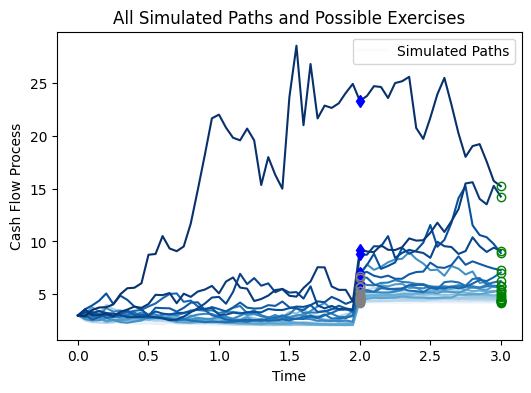

In [9]:
# Plot all exercises and continuation
grey, green = "#dddddd", "#afe1af"
plt.figure(figsize=FIGSIZE)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))

plt.plot(TIME_ARRAY, lpv.cashflow)
plt.plot(d2sl(lpv.completion_times), d2sl(lpv.completion_vals), "bd")
plt.plot(d2sl(lpv.abandon_times), d2sl(lpv.abandon_vals), "rx")
plt.plot(d2sl(lpv.success_times), d2sl(lpv.success_vals), "go", markerfacecolor='none')
plt.plot(d2sl(lpv.failure_times), d2sl(lpv.failure_vals), "ro", markerfacecolor='none')
plt.plot(d2sl(lpv.continue_times), d2sl(lpv.continue_vals), "o", color="grey", markerfacecolor='none')

plt.title("All Simulated Paths and Possible Exercises")
plt.legend(["Simulated Paths"])
plt.xlabel("Time")
plt.ylabel("Cash Flow Process")

plt.show()


NameError: name 'cashflow' is not defined

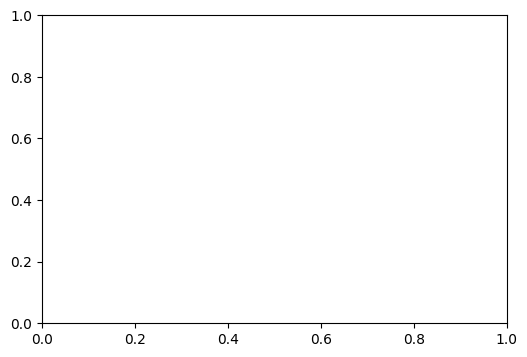

In [10]:
# Formatting for decision types
FORMATS = {
    0: ("--", "grey", "d", "blue", ":", "blue"),  # completion
    1: ("--", "grey", "x", "red", "--", "grey"),    # abandon
    2: ("--", "grey", "o", "green", ":", "green"), # success
    3: ("--", "grey", "x", "red", "--", "grey"),    # failure
}

# Plot exercise and continuation
grey = "#dddddd"
plt.figure(figsize=FIGSIZE)
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N)))
)

# given ex_id, cf, ex_line, ex_color, pre_ex_line, pre_ex_color, post_ex_line, post_ex_color, 
n_timesteps, n_paths = cashflow.shape
for ex_type, ex_idx, ex_time, ex_val, path in lpv.paths.values():
    # create a new time array depending on the length of the path
    nobs = path.shape[0]-1
    t = np.linspace(0, nobs/STEP, nobs+1)
    # active paths
    (handle_path,) = plt.plot(
        t[0 : ex_idx+1],
        path[0 : ex_idx+1],
    )
    # stopped paths
    (handle_stopped_path,) = plt.plot(
        t[ex_idx :],
        path[ex_idx :],
        FORMATS[ex_type][4],
        color=FORMATS[ex_type][5] 
    )
    # exercise point
    (handle_first_ex,) = plt.plot(
        ex_time, ex_val,
        FORMATS[ex_type][2],
        color=FORMATS[ex_type][3]
    )

plt.legend(
    [handle_path, handle_stopped_path],
    ["Path before exercise", "Path after exercise"],
)
plt.title("All Simulated Paths with Early Exercise")
plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
plt.show()


# Valuation
To calculate the valuation of the project
- We note that the cost of each path is an annuity until completion. That is, we can calculate the present value of an annuity with a coupon of the development cost rate (continuous compounding).
- For successful paths we add to that the cost of operations as well as the three-period cashflow annuity from the project.


In [ ]:
valuation = lpv.valuation()
print(f"Value of the project is: ${valuation}")


Value of the project is: $8.19579872526898


# Sensitivity Analysis
Now we vary our parameters, calculate new cashflows, and generate valuations.
- r (drift)
- sigma (volatility)


In [ ]:
# # Default Simulation Parameters
# N = 25        # no simulations
# T = 3         # simulation periods
# STEP = 20     # timesteps per period
# DRIFT = 0.02  # cashflow drift rate
# VOL = 1.0     # cashflow volatility
# START = 3.0   # initial cashflow rate c0

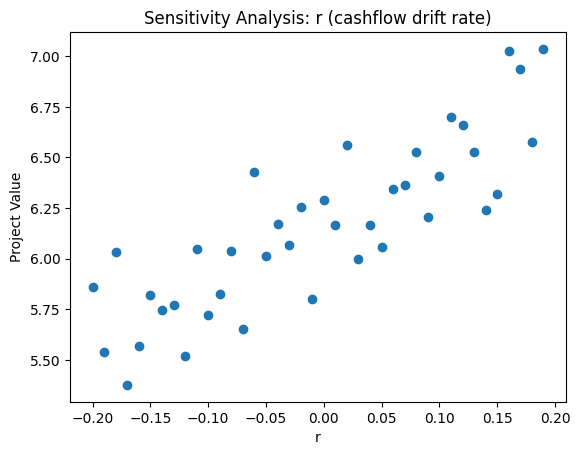

In [ ]:
# Simulate r
N = 1000
STEP = 100
TIME_ARRAY = np.linspace(0, T, STEP*T+1)

r_range = np.arange(-0.2, 0.2, 0.01)
rnd = RandomState(seed=1234)
r_cfs = [CashflowProcess(mu=r, sigma=VOL).simulate(TIME_ARRAY, N, STEP, rnd) for r in r_range]
r_cds = [CostProcess(1).generate(TIME_ARRAY) for r in r_range]
r_cos = [CostProcess(0.5).generate(TIME_ARRAY)  for r in r_range]
# Valuation
r_vals = [LeanProjectValuation(cp[0], cd, co).valuation() for cp, cd, co in zip(r_cfs, r_cds, r_cos)]

# Plot results
plt.title("Sensitivity Analysis: r (cashflow drift rate)")
plt.xlabel("r")
plt.ylabel("Project Value")
plt.scatter(r_range, r_vals)
plt.show()

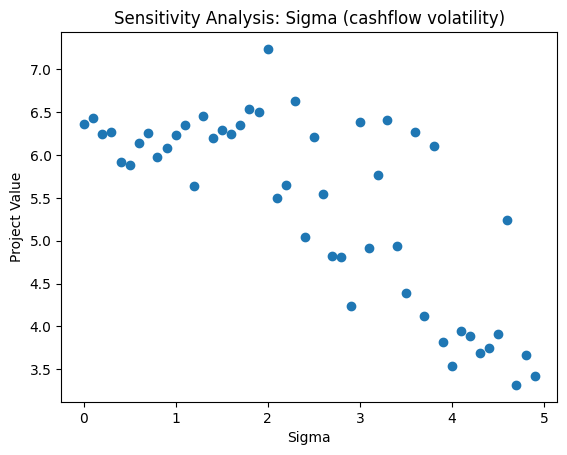

In [ ]:
# Simulate volatility
N = 1000
STEP = 100
TIME_ARRAY = np.linspace(0, T, STEP*T+1)

sigma_range = np.arange(0, 5, 0.1)
rnd = RandomState(seed=1234)
rnd = RandomState()
sigma_cfs = [CashflowProcess(mu=DRIFT, sigma=s).simulate(TIME_ARRAY, N, STEP, rnd) for s in sigma_range]
sigma_cds = [CostProcess(1).generate(TIME_ARRAY) for s in sigma_range]
sigma_cos = [CostProcess(0.5).generate(TIME_ARRAY)  for s in sigma_range]
# Valuation
sigma_vals = [LeanProjectValuation(cp[0], cd, co).valuation() for cp, cd, co in zip(sigma_cfs, sigma_cds, sigma_cos)]

# Plot results
plt.title("Sensitivity Analysis: Sigma (cashflow volatility)")
plt.xlabel("Sigma")
plt.ylabel("Project Value")
plt.scatter(sigma_range, sigma_vals)
plt.show()